# SETUP
***

Tópico destinado a configuração do notebook (importação das bibliotecas, criação de função, configuração de gráficos) e leitura inicial dos dados. 

## Bibliotecas

In [545]:
# Dados

import pandas as pd
import numpy as np 

# DataViz

import matplotlib.pyplot as plt 
import seaborn as sns
from ipywidgets import interact

# Estatística

from scipy.stats import normaltest, mannwhitneyu, wilcoxon

#ML

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix,r2_score

# Outros

import pickle
import warnings

In [461]:
warnings.filterwarnings("ignore")

## Funções

## Configurações de Gráficos

In [462]:
sns.set(style="darkgrid", palette="Accent") 
plt.rcParams["figure.figsize"] = (15, 6)  

## Leitura dos dados

In [463]:
df = pd.read_csv('../Database/customer_database_case_study.csv')

# Entendimento de negócio
***

De acordo com a solicitação do time de crédito, esse estudo tem os seguintes objetivos:


1) Entender se a política de crédito atual tem relação com o comportamento final do cliente, se está impedindo de clientes com probabilidade de inadimplência de receber o crédito.


2) Compreender quais principais variáveis impactam no índice de clientes inadimplentes e como é a relação dessas variáveis com o modelo de score atual para propor possíveis melhorias na política de crédito. 


3) Com base nas respostas dos problemas anteriores entender se é possível auxiliar os clientes que tiveram crédito negado. 

# Entendimento dos Dados

colocar um resumo dos dados e quais tratamentos vão precisar ser aplicados

In [464]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        10000 non-null  int64  
 1   ApplicationDate   10000 non-null  object 
 2   CreditAmount      10000 non-null  int64  
 3   PersonType        10000 non-null  object 
 4   ApprovalStatus    10000 non-null  object 
 5   ProductType       10000 non-null  object 
 6   City              9486 non-null   object 
 7   PersonIncome      4688 non-null   float64
 8   PersonAge         4703 non-null   float64
 9   CompanyRevenue    4800 non-null   float64
 10  CompanyAge        4817 non-null   float64
 11  EconomicActivity  4796 non-null   object 
 12  CreditScore       10000 non-null  int64  
 13  DefaultStatus     4954 non-null   float64
dtypes: float64(5), int64(3), object(6)
memory usage: 1.1+ MB


A coluna Id será removida já que não terá utilidade para análise. Após isso será realizado alguns processos de limpeza e engenharia no dataset, a fim de otimizar para as análises.

In [465]:
df.drop(columns='CustomerID', inplace=True)

# Tratamento dos dados
***

Tópico destinado ao tratamento de dados (verificação de nulos, zeros, outliers).

Tratar engenharia das colunas (criar coluna unificada de idade, renda), transformar o pedido de credito em dias (em relação a data atual), limpar nulos, zeros, duplicados, outliers. 

Notei que o Dataset apresenta uma organização do tipo wide format, a fim de otimizar o dataframe para análise e modelagem irei organizar o Dataset em long format, unificando as colunas de Idade e Renda PF e PJ.

In [466]:
df_pj = df[df['PersonType'] == 'PJ'][['ApplicationDate','CreditAmount','PersonType','ApprovalStatus','ProductType','City','CompanyRevenue','CompanyAge','EconomicActivity','CreditScore','DefaultStatus']]
df_pj.rename(columns={'CompanyAge':'Age','CompanyRevenue':'Revenue'}, inplace=True)
df_pf = df[df['PersonType'] == 'PF'][['ApplicationDate','CreditAmount','PersonType','ApprovalStatus','ProductType','City','PersonIncome','PersonAge','EconomicActivity','CreditScore','DefaultStatus']]
df_pf.rename(columns={'PersonAge':'Age','PersonIncome':'Revenue'}, inplace=True)
df = pd.concat([df_pj,df_pf], axis=0)

O próximo tratamento que irei realizar é transformar a data da tomada de crédito em dias até o dia de hoje (20/08/2024), para criar uma nova variável que pode ser útil pra identificar padrões.

In [467]:
df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], format='%Y-%m-%d')
df['ApplicationDate'] = (pd.Timestamp.today() - df['ApplicationDate']).dt.days

## Nulos, Duplicados, Zeros
***

Agora será verificado a presença de nulos, zeros desnecessários e dados duplicados, e seguir com o processo de limpeza. Para esse processo primeiramente irei verificar quais colunas possuem dados nulos em excesso, depois explorar alguns dados descritivos das variáveis, além de plotar a distribuição dos dados para compreender qual o tratamento mais adequado.

In [468]:
nulos = pd.DataFrame(data=[df.isnull().sum(),(df.isnull().sum() / len(df)) * 100]).T
nulos.columns = ['Absoluto', 'Percentual']
nulos

,Absoluto,Percentual
ApplicationDate,0.0,0.00
CreditAmount,0.0,0.00
PersonType,0.0,0.00
ApprovalStatus,0.0,0.00
ProductType,0.0,0.00
City,514.0,5.14
Revenue,512.0,5.12
Age,480.0,4.80
EconomicActivity,5204.0,52.04
CreditScore,0.0,0.00


In [469]:
df.describe().round(2)

,ApplicationDate,CreditAmount,Revenue,Age,CreditScore,DefaultStatus
count,10000.00,10000.00,9488.00,9520.00,10000.00,4954.00
mean,416.41,4887.49,274097.79,26.69,574.97,0.19
std,104.72,4872.02,410243.53,21.35,182.17,0.39
min,235.00,0.00,349.00,0.00,200.00,0.00
25%,327.00,1414.00,30508.25,7.00,446.00,0.00
50%,416.00,3392.00,90553.00,22.00,589.00,0.00
75%,507.00,6735.75,354813.50,44.00,701.00,0.00
max,598.00,40862.00,3834176.00,89.00,900.00,1.00


In [470]:
@interact(Variável=['Revenue','Age'])
def histograma_interativo(Variável):
    plt.figure(figsize=(12,6))
    sns.histplot(df[Variável], kde=True)

interactive(children=(Dropdown(description='Variável', options=('Revenue', 'Age'), value='Revenue'), Output())…

Antes de seguir com o tratamento dos dados verifiquei que a variável idade tem o valor mínimo de 0 e o primeiro quartil em 7. Isso faz sentido para clientes PJ, porém não faz sentido para clientes PF já que menores não podem tomar crédito, e por isso irei me certificar que esse valor corresponde a clientes PJ!

In [471]:
print('Idade Mímina Clientes PF: {}'.format(df[df['PersonType'] == 'PF']['Age'].min()))

Idade Mímina Clientes PF: 18.0


### Nulos
*** 


Como foi possível ver na contagem de nulos  acima as variáveis de cidade, receita, idade, atividade economica, e status de inadimplência possuem valores nulos, e receberão as seguintes tratativas:

Atividade Economica (EconomicActivity) - A coluna será removida, já que possue dados apenas para clientes PJ o que pode não ser uma variável explicativa interessante nesse estudo. 

Cidade (City) - Como se trata de poucos dados serão apenas removidos. 

Receita (Revenue) e Idade (Age) - Não tem caracteristica de uma distribuição normal (conforme foi possível verificar nos histogramas plotados), portanto serão preenchidas com a mediana da variável para evitar viés dos possíveis outliers. 

Status de inadimplência (DefaultStatus) - Os valores nulos nessa coluna tem relação com aprovação do crédito ou não. Para facilitar no desenvolvimento dos dois primeiros objetivos serão escolhidos apenas os clientes que tiveram crédito concedido. Os clientes que não tiveram a concessão serão utilizados apenas para o desenvolvimento do terceiro objetivo.

In [472]:
#EconomicActivity 

df.drop(columns='EconomicActivity',inplace=True)

#City 

df.dropna(subset=['City'], inplace=True)

#Revenue e Age

df['Revenue'].fillna(df['Revenue'].median(),inplace=True)
df['Age'].fillna(df['Age'].median(),inplace=True)

In [473]:
df_aproval = df.dropna(subset=['DefaultStatus'])
df_n_aproval = df[df['DefaultStatus'].isnull()]

df_cleaning = df_aproval.drop(columns='ApprovalStatus')

### Zeros
***

O objetivo dessa análise é verificar a presença de zeros que fuja do padrão da variável. 

In [474]:
(df_cleaning == 0).sum()

ApplicationDate       0
CreditAmount          0
PersonType            0
ProductType           0
City                  0
Revenue               0
Age                  91
CreditScore           0
DefaultStatus      3829
dtype: int64

Os dados fazem sentido com as variáveis, já que na variável idade existem clientes PJ no primeiro ano da empresa, e na variável target se trata de um booleano. 

### Duplicados

In [475]:
print(f'O dataset possue {df_cleaning.duplicated().sum()} dados duplicados')

O dataset possue 0 dados duplicados


### Outliers

In [476]:
@interact(Variável=['ApplicationDate','CreditAmount','Revenue','Age','CreditScore'])
def boxplot_interativo(Variável):
    plt.figure(figsize=(20,6))
    sns.boxplot(df_cleaning, x=Variável)

interactive(children=(Dropdown(description='Variável', options=('ApplicationDate', 'CreditAmount', 'Revenue', …

As variáveis valor solicitado (CreditAmount) e receita (Revenue) possuem outliers, porém ao modelar uma regressão será aplicado uma transformação (StandartdScale) para que o modelo não sofra confusão em relação as grandezas de números, e com isso o impacto desses outliers tende a diminuir. 

# EDA 
***

Esse tópico será focado em responder as seguintes questões:

1) A política de crédito atual tem relação com o comportamento final do cliente? Está impedindo que clientes com probabilidade de inadimplência receba o crédito ?

    Para esse questão a principal ferramenta será um teste de hipótese a fim de afirmar se existe essa relação ou não. Porém antes será necessário entender como a variável CreditScore se comporta, para definir qual teste será realizado.


2) Quais principais variáveis ajudam a identificar prováveis clientes indimplentes? 

    Para responder essa questão será feito um modelo de regressão logística, para entender a relação da variável dependente (DefaultStatus) representado pela letra y, com as variáveis independentes (as outras variáveis do dataset) e como elas conseguem explicar o comportamento dos possíveis clientes indadimplentes. Posteriormente será feito um modelo de regressão linear com as mesmas variáveis tendo como variável dependente a política de crédito (CreditScore), a fim de entender a relação delas com a política e sugerir possíveis melhorias.

## 1) A política de crédito atual tem relação com o comportamento final do cliente? Está impedindo que clientes com probabilidade de inadimplência receba o crédito ?

In [477]:
df_cleaning['DefaultStatus'].value_counts(normalize=True)

DefaultStatus
0.0    0.814161
1.0    0.185839
Name: proportion, dtype: float64

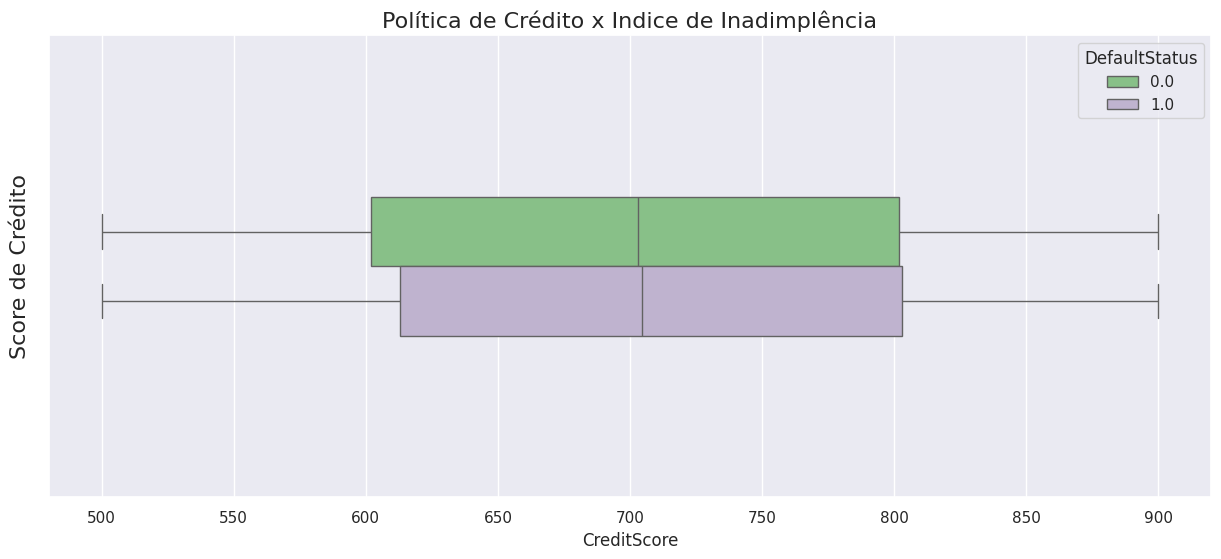

In [478]:
ax = sns.boxplot(data = df_cleaning, x= 'CreditScore', hue='DefaultStatus',width=0.3)
ax.set_title('Política de Crédito x Indice de Inadimplência', fontsize=16)
ax.set_ylabel('Score de Crédito', fontsize=16);

Em uma análise descritiva foi possível notar que da amostra de clientes que tiveram crédito aprovado 81,41% foram adimplentes. Na análise gráfica é notavel que o comportamento do score de crédito não tem gerado impacto em relação aos clientes inadimplentes (1), já que apresenta um comportamento muito similar ao dos clientes adimplentes (0). Para confirmar se existe o score impacta no fato do clientes ser inadimplente ou não será realizado um teste de hipótese, porém antes será necessário entender o comportamento da variável CreditScore através de um histograma para compreender se a distribuição dos dados segue uma normal, o que vai direcionar a escolha do nosso teste, já que caso siga uma normal será aplicado o teste paramétrico de duas amostras, e caso não siga será aplicado o teste de Mann-Whitney.

<Axes: xlabel='CreditScore', ylabel='Count'>

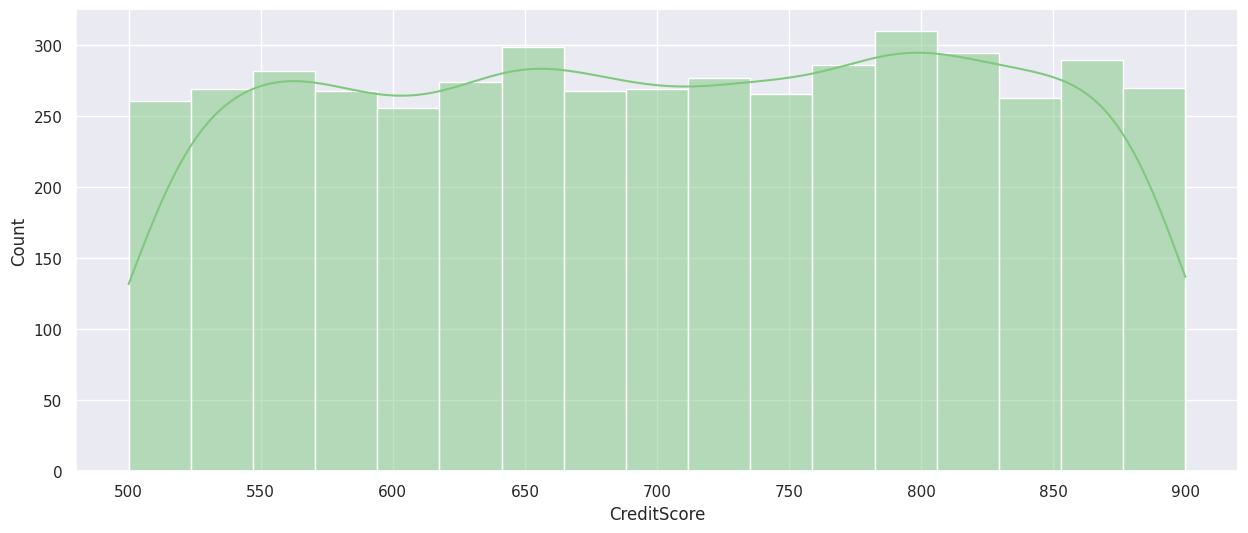

In [479]:
sns.histplot(df_cleaning['CreditScore'], kde=True)

Através da análise gráfica a distribuição aparenta ser uniforme. Irei confirmar isso aplicando um normal test que testa hipótese nula $H_0$ de que a amostra é proveniente de uma distribuição normal. Para o teste será utilizado um nível de significancia de 5%.

H0: A amostra é proveniente de uma normal


H1: A amostra não proveniente de uma normal

In [480]:
stat_test, pvalor = normaltest(df_cleaning['CreditScore'])

if pvalor < 0.05:
    print('Rejeitar H0: A variável não se trata de uma normal')
else:
    print('Não Rejeitar H0: A variável se trata de uma normal')

Rejeitar H0: A variável não se trata de uma normal


Como foi confirmado que a variável não se trata de uma normal seguirei com a utilização do teste de Mann-Whitney. Ele será um teste bicaudal que vai teste se existe diferença entre a média de score de clientes adimplentes e inadimplentes.

H0: Não existe diferença na média de score dos clientes adimplentes e inadimplentes


H1: Existe diferença na média de score dos clientes adimplentes e inadimplentes


In [481]:
adimplentes = df_cleaning.query('DefaultStatus == 0')['CreditScore']
inadimplentes = df_cleaning.query('DefaultStatus == 1')['CreditScore']

In [482]:
U, p_valor = mannwhitneyu(adimplentes, inadimplentes, alternative='two-sided')

if p_valor < 0.05:
    print('Rejeitar H0: Existe diferença significativa nas médias de score dos clientes adimplentes e inadimplentes')
else:
    print('Não Rejeitar H0: Não existe evidência estatística de que existe diferença significativa nas médias de score dos clientes adimplentes e inadimplentes')

Não Rejeitar H0: Não existe evidência estatística de que existe diferença significativa nas médias de score dos clientes adimplentes e inadimplentes


Conforme testes realizados, na amostra coletada não existe evidência estatística forte suficiente para afirmar que atual política de crédito está conseguindo avaliar bem o comportamento dos clientes e impedir que o crédito seja concedido para clientes que venham a se tornar inadimplentes.


Após obtenção da primeira resposta irei fazer algumas análises e um modelo de regressão logísticas para compreender o comportamento dos clientes inadimplentes.

## 2) Quais principais variáveis ajudam a identificar prováveis clientes indimplentes? 
***
Vou realizar algumas análises descritivas para compreender quais variáveis podem ter impacto ou não na variável dependente. 

In [483]:
@interact(Váriavel=['PersonType','ProductType','City'])
def barplot_interactive(Váriavel):
    tx_inadimplencia = (df_cleaning.groupby(Váriavel)['DefaultStatus'].mean() * 100).round(2).reset_index()
    ax = sns.barplot(x=Váriavel, y='DefaultStatus', data=tx_inadimplencia)
    ax.set_ylabel('Taxa de Inadimplência')

interactive(children=(Dropdown(description='Váriavel', options=('PersonType', 'ProductType', 'City'), value='P…

Através da análise gráfica foi possível constatar que todas variáveis categóricas apresentam diferenças das taxas de inadimplência, o que aponta que essas variáveis podem ser relevantes para explicação da target, e por isso devem entrar no modelo. Para isso serão transformadas em variáveis dummies.


Em seguida vou validar as variáveis numéricas para compreender a relação com variável target.

In [484]:
df_cleaning.select_dtypes(include=['number']).corr()

,ApplicationDate,CreditAmount,Revenue,Age,CreditScore,DefaultStatus
ApplicationDate,1.000000,-0.017655,0.008414,0.005666,0.017478,0.009579
CreditAmount,-0.017655,1.000000,0.010298,-0.012057,0.009411,0.002567
Revenue,0.008414,0.010298,1.000000,-0.404870,-0.017418,-0.126826
Age,0.005666,-0.012057,-0.404870,1.000000,0.011357,0.165524
CreditScore,0.017478,0.009411,-0.017418,0.011357,1.000000,0.016354
DefaultStatus,0.009579,0.002567,-0.126826,0.165524,0.016354,1.000000


In [485]:
@interact(Variável=['ApplicationDate','CreditAmount','Revenue','Age','CreditScore'],
         Filtro = ['PersonType','ProductType','City'])
def lmplot_interact(Variável, Filtro):
    ax= sns.lmplot(y=Variável, x="DefaultStatus", data=df_cleaning, col=Filtro, legend=True)
    ax.fig.suptitle(f'Reta de Regressao - Inadimplência X {Variável}', fontsize=16, y=1.02)
    ax.set_xlabels("Inadimplência", fontsize=14)
    ax.set_ylabels(Variável, fontsize=14);

interactive(children=(Dropdown(description='Variável', options=('ApplicationDate', 'CreditAmount', 'Revenue', …

Observando as variáveis contínuas foi possível constatar que as que podem ter maior impacto no modelo é idade e o renda. A relação seria quanto maior a idade maior a chance de inadimplência, e quanto menor a receita maior a chance de inadimplência, análise que faz muito sentido do ponto de vista de negócio.

Para sequência irei fazer as transformações necessárias nas variáveis e criar o modelo.

### Modelagem 
*** 

Antes de seguir com o treinamento do modelo vou separar a variável target (y) das variáveis explicativas (X). Depois realizarei dois processos:

Variáveis numéricas: Fazer um trasnformação com StandartdScale.

Variáveis Categóricas: Criar variáveis Dummies.

In [486]:
y = df_cleaning['DefaultStatus'].reset_index(drop=True)

X = df_cleaning[['ApplicationDate','CreditAmount','PersonType','ProductType','City','Revenue','Age','CreditScore']].reset_index(drop=True)

In [487]:
x_numeric = X.select_dtypes(include=['number'])
x_categorical = X.select_dtypes(include=['object'])

# Escalonamento 

scale = StandardScaler()
x_numeric = pd.DataFrame(scale.fit_transform(x_numeric), columns=x_numeric.columns)

# Dummies

x_categorical = pd.get_dummies(x_categorical)

# X

X = pd.concat([x_numeric,x_categorical],axis=1)


Após as transformações seguirei com a criação do modelo e apuração dos resultados.

In [488]:
#Modelo 

lr = LogisticRegression(class_weight='balanced')

lr.fit(X, y);

y_predict = lr.predict(X)

print(f'Acurácia: {(lr.score(X, y) * 100):.2f}%')


Acurácia: 65.36%


In [489]:
classes = lr.classes_.astype('str')
print(classification_report(y_true=y, y_pred=y_predict, target_names=classes))

              precision    recall  f1-score   support

         0.0       0.89      0.66      0.75      3829
         1.0       0.30      0.65      0.41       874

    accuracy                           0.65      4703
   macro avg       0.60      0.65      0.58      4703
weighted avg       0.78      0.65      0.69      4703



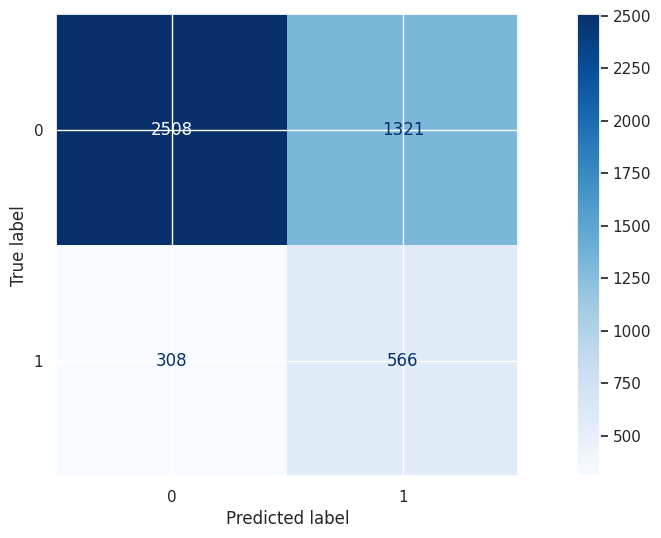

In [490]:
ax = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, y_predict))
ax.plot(cmap=plt.cm.Blues)
plt.show()

Observando o resultado da regressão logística foi possível ver que o modelo foi capaz de acertar 65.36% das classes da nossa base, além disso o modelo foi satisfatório quanto acertar a classe de clientes inadimplentes, tendo um recall de  65%, o que é aceitável visto que o objetivo do modelo que é entender as variáveis explicativas dos clientes inadimplentes. O modelo não foi totalmente acertivo por ser sensível ao desbalanceamento de classes, para resolver esse problema visando construir um modelo capaz de prever a inadimplência é recomendado utilizar modelos mais robustos (como os modelos de árvore) ou realizar tratamento de balanceamento de classes. 

Seguindo com a nossa análise, irei plotar a importancia das variáveis de independentes no modelo, para que seja possível entender como cada uma delas auxilía na definição de clientes inadimplentes. 

### Variáveis Explicativas

<Axes: >

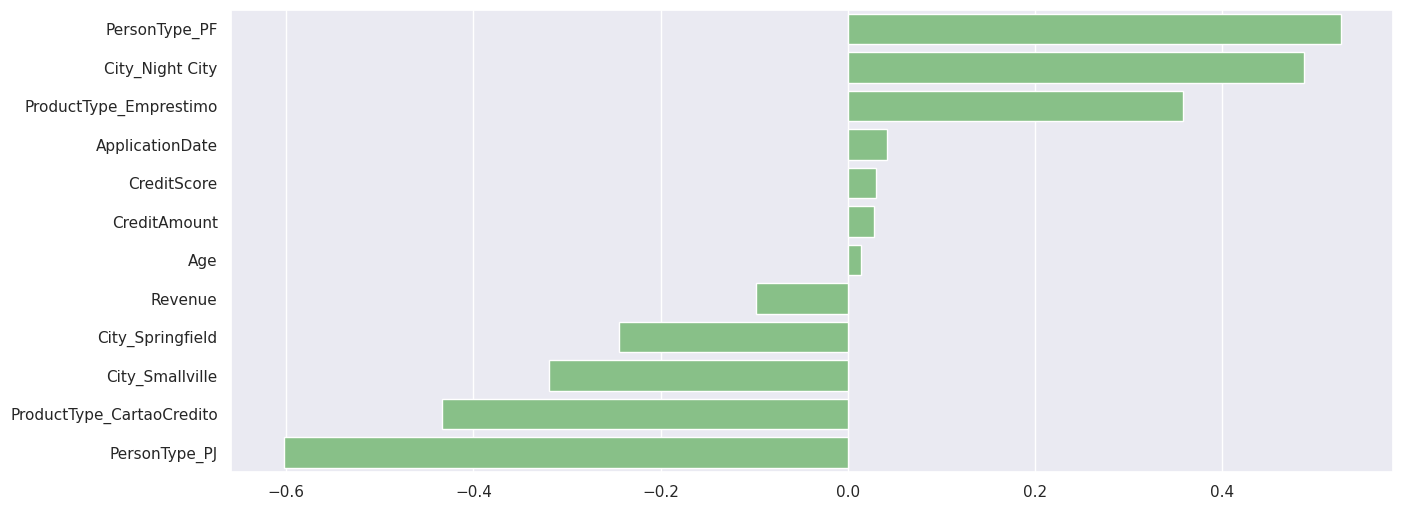

In [491]:
sns.barplot(pd.Series(lr.coef_[0], index=X.columns).sort_values(ascending=False), orient='h')

Ao analisar as variáveis explicativas, é possível observar que algumas tendem mais à direita e outras à esquerda. As variáveis que estão mais à esquerda (com valores negativos mais altos) explicam a tendência dos clientes a não serem inadimplentes, enquanto as variáveis mais à direita (com valores positivos mais altos) explicam a tendência dos clientes a se tornarem inadimplentes.

Pontos Explicatívos:

1) Segundo o modelo clientes PF, que residem em Night City, ou tem como produto empréstimos, são clientes com tendência maior de se tornarem inadimplentes. Isso faz sentido do ponto de vista de negócios, pois clientes com empréstimos geralmente tomam crédito de uma vez só, frequentemente para adquirir bens de maior valor e com juros mais altos, o que pode dificultar o pagamento e aumentar o risco de inadimplência em comparação com clientes que utilizam cartões de crédito, onde o limite é concedido aos poucos. O fato de pessoas físicas apresentarem maior tendência também faz sentido, já que empresas tendem a evitar comprometer-se financeiramente para evitar problemas jurídicos que possam impactar gravemente seus resultados.

2) Em contraste, a variável receita, que explica a tendência dos clientes a não serem inadimplentes, faz sentido, pois quanto maior a receita da pessoa ou empresa, menor o risco de inadimplência.

3) Outro ponto interessante é que variável política de crédito (CreditScore) pouco impactou no modelo, o que corrobora com análise feita no tópico anterior.

4) Quanto ao impacto positivo e nagativo das cidades recomendo um estudo demográfico mais aprofundado para entender esse impacto. 





### Entendendo as relações das variáveis independente com a política de crédito para compreender se existe uma possível melhoria a ser realizada.
***

Vou realizar um estudo similar, porém tomando como variável dependente a política de cŕedito para entender a relação dela com as variáveis e comparar os dois estudos, sugerindo assim (ou não) melhorias na política de crédito, com base nas diferenças.

In [492]:
y = df_cleaning['CreditScore'].reset_index(drop=True)

X = df_cleaning[['ApplicationDate','CreditAmount','PersonType','ProductType','City','Revenue','Age']].reset_index(drop=True)

In [493]:
 @interact(Variáveis=['PersonType','ProductType','City'])
 def score_interact(Variáveis):
    ax = sns.boxplot(data = df_cleaning, x= 'CreditScore', hue=Variáveis ,width=0.2)
    ax.figure.set_size_inches(12,6)
    ax.set_title('Política de Crédito', fontsize=16)
    ax.set_ylabel('Score', fontsize=16)

interactive(children=(Dropdown(description='Variáveis', options=('PersonType', 'ProductType', 'City'), value='…

Visualizando o impacto das variáveis catégoricas na variável dependente foi possível notar que apenas o tipo de pessoa (PF ou PJ) apresenta um leve impacto (pessoas físicas tendem a ter um score um pouco maior). As outras variáveis geram pouca variação no Score.

In [494]:
@interact(Variáveis=['ApplicationDate','CreditAmount','Revenue','Age'])
def joinplot_intect(Variáveis):
    ax = sns.jointplot(x=Variáveis, y="CreditScore", data=df_cleaning,kind='reg')
    ax.fig.suptitle(f'Dispersao - CreditScore x {Variáveis}', fontsize=18, y=1.05)
    ax.set_axis_labels("CreditScore", Variáveis, fontsize=14)


interactive(children=(Dropdown(description='Variáveis', options=('ApplicationDate', 'CreditAmount', 'Revenue',…

Não foi possível encontrar correlações significativas entre a variável dependente as variáveis independentes. Vou seguir com os mesmos preprocessamentos do modelo anterior e criar o modelo de regressão linear. 

In [495]:
numeric = df_cleaning.select_dtypes(include=['number'])
numeric.drop(columns='DefaultStatus', inplace=True)
x_categorical = X.select_dtypes(include=['object'])

# Escalonamento 

scale = StandardScaler()
numeric = pd.DataFrame(scale.fit_transform(numeric), columns=numeric.columns)
y = numeric['CreditScore']
x_numeric = numeric.drop(columns='CreditScore')

# Dummies

x_categorical = pd.get_dummies(x_categorical)

# X

X = pd.concat([x_numeric,x_categorical],axis=1)

In [496]:
lr = LinearRegression()

lr.fit(X,y);

y_predict = lr.predict(X)

print(f'R²: {r2_score(y, y_predict) * 100:.2f}%')

R²: 0.08%


O modelo desenvolvido revelou que apenas 7,68% da variação do Score é explicado pelas variáveis independentes analisadas. Esse resultado é consistente com as análises descritivas prévias e reforça a conclusão de que a política de crédito atual não está sendo efetiva na identificação de clientes com tendência à inadimplência.

Diante disso, recomendo ao time de Crédito um ajuste na política, fundamentado nas variáveis que demonstraram ser mais preditivas da inadimplência. Com essa abordagem, o Score se tornará mais preciso e útil tanto para facilitar a concessão de crédito a clientes com boas características quanto para mitigar riscos, tornando a política mais eficaz na previsão de inadimplência.

## 3) Com base na identificação da necessidade de melhoria da política de crédito, existe uma relação com os clientes que tiveram crédito negado?

***

Neste último objetivo, buscarei entender se há uma relação entre os clientes que tiveram crédito negado e a política de crédito atual. Caso essa relação seja identificada, utilizarei a amostra de clientes com a variável alvo (DefaultStatus) para treinar um modelo de classificação mais robusto do que a regressão logística. O objetivo é desenvolver um modelo capaz de prever com precisão quais clientes tem tendência a inadimplência e identificar aqueles que podem passar por uma reavaliação de crédito, auxiliando o time de Crédito a conceder mais crédito a clientes com tendência a serem bons pagadores.



In [497]:
df = pd.concat([df_aproval,df_n_aproval]).reset_index()

In [498]:
df

,index,ApplicationDate,CreditAmount,PersonType,ApprovalStatus,ProductType,City,Revenue,Age,CreditScore,DefaultStatus
0,1,589,15051,PJ,APPROVED,CartaoCredito,Springfield,374600.0,9.0,810,0.0
1,5,352,848,PJ,APPROVED,CartaoCredito,Night City,536672.0,39.0,708,0.0
2,12,589,8932,PJ,APPROVED,Emprestimo,Smallville,141081.0,15.0,518,0.0
3,16,518,1814,PJ,APPROVED,CartaoCredito,Night City,394356.0,14.0,506,0.0
4,19,596,1721,PJ,APPROVED,CartaoCredito,Smallville,92704.0,4.0,780,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9481,9981,578,4623,PF,DENIED,CartaoCredito,Smallville,90583.0,52.0,351,NaN
9482,9983,558,12030,PF,DENIED,Emprestimo,Smallville,11874.0,23.0,291,NaN
9483,9986,503,1964,PF,DENIED,CartaoCredito,Springfield,84311.0,27.0,656,NaN
9484,9989,504,8459,PF,DENIED,CartaoCredito,Night City,7387.0,22.0,282,NaN


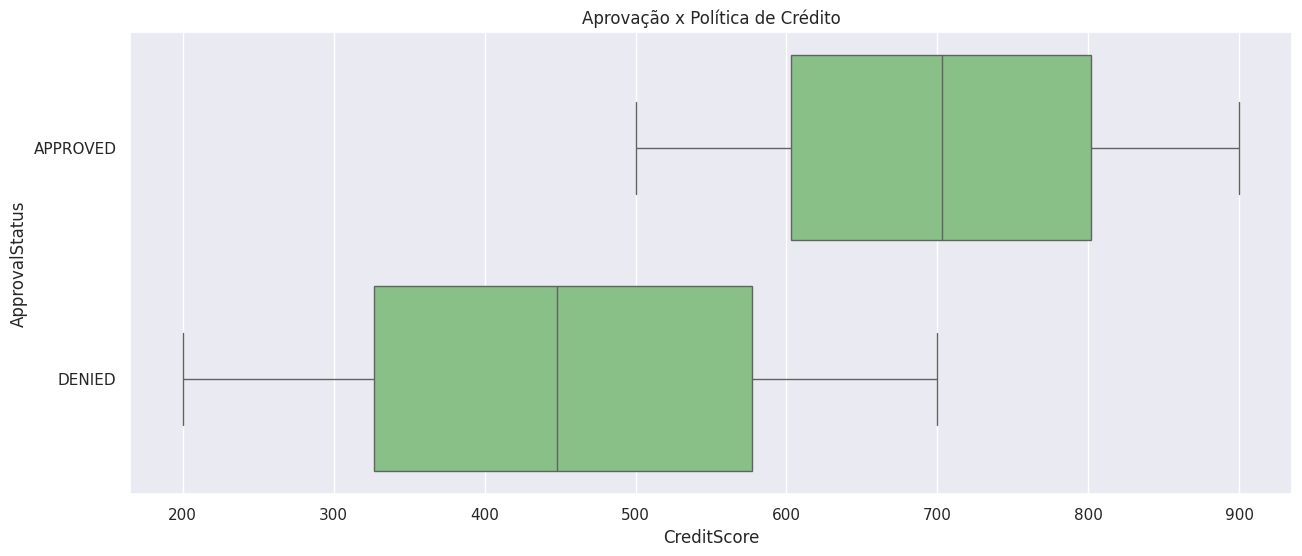

In [499]:
ax = sns.boxplot(df, x = 'CreditScore', y='ApprovalStatus')
ax.set_title('Aprovação x Política de Crédito');

Através da análise gráfica foi possível constatar diferente comportamento da política de crédito de clientes que tiveram o crédito negado e aprovado. Clientes que foram negados possuem uma mediana menor de score de crédito, o que da pra entender que a política teve uma relação direto com o fato de não terem a concessão. Vou realizar um teste de hipóteses para confirmar essa relação.

<Axes: xlabel='CreditScore', ylabel='Count'>

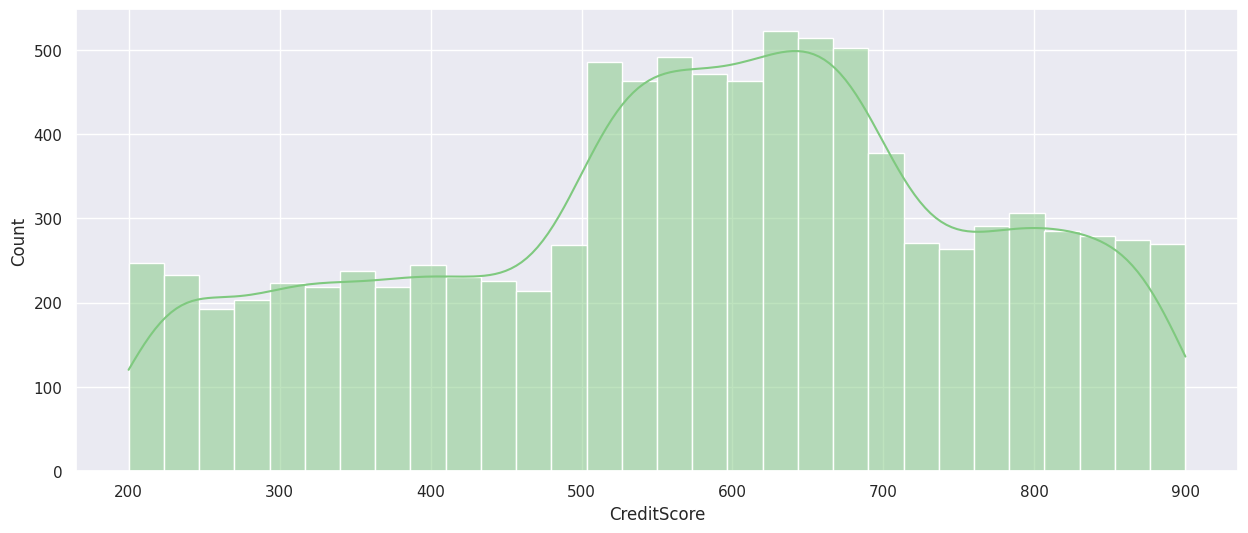

In [500]:
sns.histplot(df['CreditScore'],kde=True)

In [501]:
stat_test, pvalor = normaltest(df['CreditScore'])

if pvalor < 0.05:
    print('Rejeitar H0: A variável não se trata de uma normal')
else:
    print('Não Rejeitar H0: A variável se trata de uma normal')

Rejeitar H0: A variável não se trata de uma normal


Como mesmo com mais amostras a variável CreditScore ainda não se comporta como uma normal, vou seguir com um teste não paramétrico. Dessa vez como as duas variáveis possue uma dependência (se o pedido foi negado ele não pode ser aceito) vou utilizar o teste Wilcoxon, que é ideal para esse tipo de problema. Para isso será selecionado 4703 amostras de cada variável (o máximo possível por conta de pedidos aprovados ser levemente menor que negado), e o teste irá ter as seguintes hipóteses:

H0: O score dos pedidos negados não é menor que dos pedidos aprovados

H1: O score dos pedidos negados é menor que dos pedidos aprovados

In [502]:
aprovado = df.query('ApprovalStatus == "APPROVED"').sample(4703, random_state=101)['CreditScore']
negado = df.query('ApprovalStatus == "DENIED"').sample(4703, random_state=101)['CreditScore']

In [503]:
T, p_valor = wilcoxon(negado, aprovado, alternative='less')

if p_valor < 0.01:
    print('Acatar H1: O score dos pedidos negados é menor que dos pedidos aprovados')
else: 
    print('Não rejeitar H0: O score dos pedidos negados não é menor que dos pedidos aprovados')

Acatar H1: O score dos pedidos negados é menor que dos pedidos aprovados


Foi possível confirmar, com 99% de confiança, que os clientes que tiveram o pedido de crédito negado foram influenciados por seus scores mais baixos. Portanto, o próximo passo será treinar um modelo de classificação com os dados dos clientes que tiveram o pedido aceito. Esse modelo será mais robusto do que a regressão logística e terá como objetivo prever quais clientes têm maior probabilidade de serem adimplentes. Com isso, esses clientes poderão ser encaminhados para uma reanálise, auxiliando o time de Crédito a conceder mais crédito para bons pagadores.

O modelo escolhido será o RandomForestClassifier, um modelo de ensemble do tipo bagging. Esse tipo de modelo combina as previsões de várias árvores de decisão para aumentar a precisão e a robustez das previsões.

 

### Modelo

In [504]:
y = df_cleaning['DefaultStatus'].reset_index(drop=True)

X = df_cleaning[['ApplicationDate','CreditAmount','PersonType','ProductType','City','Revenue','Age']].reset_index(drop=True)

In [505]:
x_numeric = X.select_dtypes(include=['number'])
x_categorical = X.select_dtypes(include=['object'])

# Escalonamento 

scale = StandardScaler()
x_numeric = pd.DataFrame(scale.fit_transform(x_numeric), columns=x_numeric.columns)

# Dummies

x_categorical = pd.get_dummies(x_categorical)

# X

X = pd.concat([x_numeric,x_categorical],axis=1)

Para uma avaliação se o modelo é capaz de desempenhar bem em dados apresentados no treinamento vou separar as variáveis em treino e teste.

In [506]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.25, random_state=42)

In [507]:
#modelo 

model = RandomForestClassifier(class_weight='balanced')

model.fit(X_train, y_train);

y_pred_train = model.predict(X_train)
y_pred_test =  model.predict(X_test)


print(f'Acurácia Treino: {(model.score(X_train, y_train) * 100):.2f}%')
print(f'Acurácia Teste: {(model.score(X_test, y_test) * 100):.2f}%')

Acurácia Treino: 100.00%
Acurácia Teste: 81.63%


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2853
         1.0       1.00      1.00      1.00       674

    accuracy                           1.00      3527
   macro avg       1.00      1.00      1.00      3527
weighted avg       1.00      1.00      1.00      3527



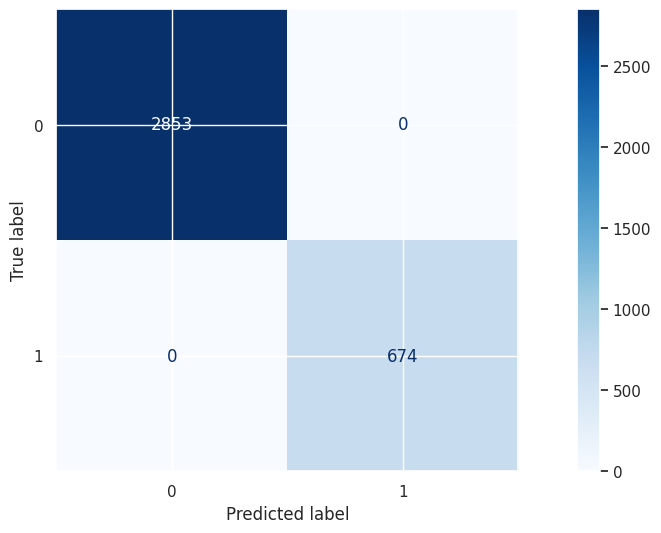

In [508]:
classes = model.classes_.astype('str')
print(classification_report(y_true=y_train, y_pred=y_pred_train, target_names=classes))

ax = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred_train))
ax.plot(cmap=plt.cm.Blues)
plt.show()

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90       976
         1.0       0.32      0.07      0.11       200

    accuracy                           0.82      1176
   macro avg       0.58      0.52      0.51      1176
weighted avg       0.75      0.82      0.76      1176



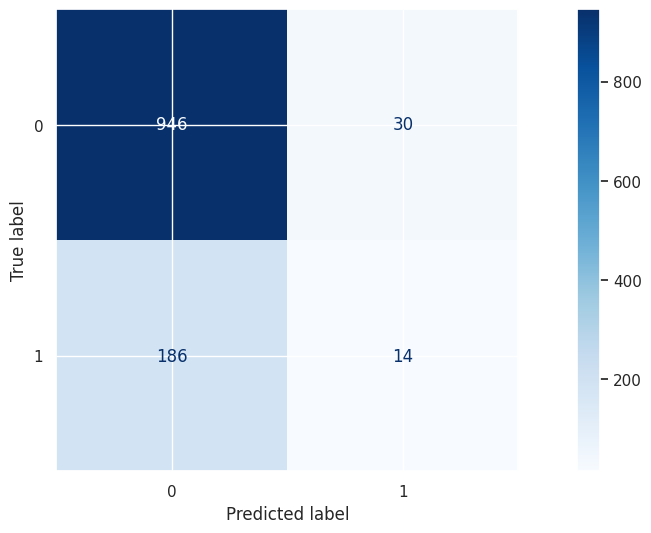

In [509]:
classes = model.classes_.astype('str')

print(classification_report(y_true=y_test, y_pred=y_pred_test, target_names=classes))


ax = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_test))
ax.plot(cmap=plt.cm.Blues)
plt.show()

Avaliando as métricas, notei que o modelo teve um ótimo desempenho com os dados de treino, mas o mesmo não ocorreu com os dados de teste. Portanto, irei realizar uma tunagem de parâmetros utilizando GridSearch para encontrar o melhor conjunto de parâmetros, de forma que o modelo seja mais eficaz em prever a categoria 1 (clientes com tendência a inadimplência) com maior precisão em dados que não foram expostos ao algoritmo.


In [510]:
parametros = {'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]}
  
grid_search = GridSearchCV(RandomForestClassifier(), parametros, scoring='f1', cv=5, n_jobs = -1)

In [511]:
grid_search.fit(X_train, y_train);

In [512]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,1.370504,0.098244,0.050236,0.003836,balanced,10,4,10,200,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.349206,0.297994,0.333333,0.337748,0.310559,0.325768,0.018723,1
21,0.659187,0.018319,0.027337,0.001942,balanced,10,4,5,100,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.344371,0.316418,0.309278,0.310345,0.288462,0.313775,0.017977,2
17,1.903732,0.081706,0.060269,0.002479,balanced,10,2,10,300,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.352941,0.278638,0.313589,0.324138,0.296530,0.313167,0.025186,3
20,1.990942,0.083899,0.066360,0.005288,balanced,10,4,2,300,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.332248,0.303030,0.303448,0.337748,0.289308,0.313157,0.018627,4
6,0.661343,0.048199,0.025762,0.002123,balanced,10,1,10,100,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.335616,0.298780,0.335714,0.327645,0.265372,0.312626,0.027246,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1.634021,0.089631,0.058081,0.005209,None,10,4,2,200,"{'class_weight': None, 'max_depth': 10, 'min_s...",0.014599,0.028571,0.014599,0.041667,0.014493,0.022786,0.010889,158
106,1.726303,0.102306,0.066241,0.006051,None,10,4,10,200,"{'class_weight': None, 'max_depth': 10, 'min_s...",0.014706,0.028571,0.014599,0.055172,0.000000,0.022610,0.018621,159
103,1.597187,0.063539,0.053906,0.002314,None,10,4,5,200,"{'class_weight': None, 'max_depth': 10, 'min_s...",0.014493,0.014388,0.014599,0.055172,0.014388,0.022608,0.016282,160
107,2.594155,0.117482,0.089447,0.007981,None,10,4,10,300,"{'class_weight': None, 'max_depth': 10, 'min_s...",0.014599,0.014286,0.028986,0.054422,0.000000,0.022458,0.018424,161


In [513]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [514]:
model_tunning = RandomForestClassifier(
bootstrap = True,
ccp_alpha = 0.0,
class_weight = 'balanced',
criterion = 'gini',
max_depth = 10,
max_features = 'sqrt',
max_leaf_nodes = None,
max_samples = None,
min_impurity_decrease = 0.0,
min_samples_leaf = 4,
min_samples_split = 10,
min_weight_fraction_leaf = 0.0,
monotonic_cst = None,
n_estimators = 200,
n_jobs = None,
oob_score = False,
random_state = None,
verbose = 0,
warm_start = False)


model_tunning.fit(X_train, y_train);

y_pred_train = model_tunning.predict(X_train)
y_pred_test =  model_tunning.predict(X_test)


print(f'Acurácia Treino: {(model_tunning.score(X_train, y_train) * 100):.2f}%')
print(f'Acurácia Teste: {(model_tunning.score(X_test, y_test) * 100):.2f}%')

Acurácia Treino: 84.92%
Acurácia Teste: 72.70%


              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90      2853
         1.0       0.57      0.87      0.69       674

    accuracy                           0.85      3527
   macro avg       0.77      0.86      0.79      3527
weighted avg       0.89      0.85      0.86      3527



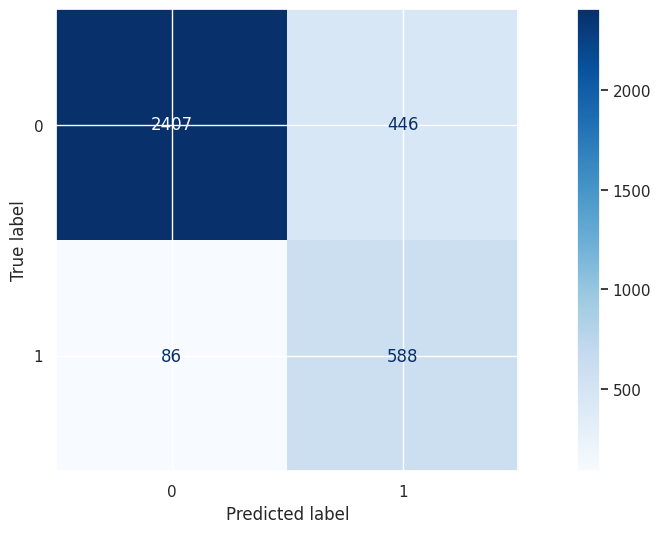

In [515]:
classes = model_tunning.classes_.astype('str')

print(classification_report(y_true=y_train, y_pred=y_pred_train, target_names=classes))

ax = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred_train))
ax.plot(cmap=plt.cm.Blues)
plt.show()

              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82       976
         1.0       0.31      0.50      0.38       200

    accuracy                           0.73      1176
   macro avg       0.60      0.64      0.60      1176
weighted avg       0.79      0.73      0.75      1176



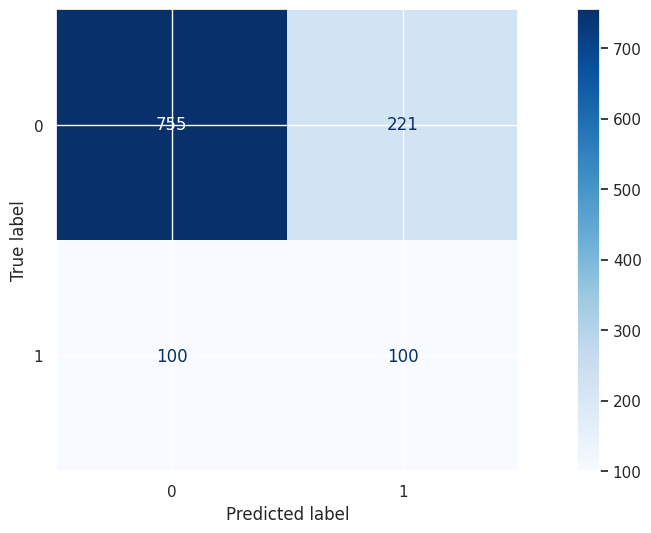

In [516]:
classes = model_tunning.classes_.astype('str')

print(classification_report(y_true=y_test, y_pred=y_pred_test, target_names=classes))

ax = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_test))
ax.plot(cmap=plt.cm.Blues)
plt.show()

O modelo melhorou consideravelmente sua capacidade de prever clientes inadimplentes e, com isso, reduziu o número de falsos positivos, ou seja, clientes que são inadimplentes e foram erroneamente classificados como adimplentes. Esse modelo será utilizado para realizar a previsão dos clientes que tiveram o crédito negado.

#### Utilizando modelo para gerar base de clientes que podem passar na reanálise!

*** 

Como não foi estruturado nenhum modelo de preprocessamento (etapa importante caso o modelo seja implantado) vou primeiramente fazer todos os passos de preprocessamento na base de clientes não aprovados.

In [532]:
df_pred = df_n_aproval.drop(columns=['ApprovalStatus','DefaultStatus','CreditScore']).reset_index(drop=True)

df_pred_numeric = df_pred.select_dtypes(include=['number'])
df_pred_categorical = df_pred.select_dtypes(include=['object'])

# Escalonamento 

scale = StandardScaler()
df_pred_numeric = pd.DataFrame(scale.fit_transform(df_pred_numeric), columns=df_pred_numeric.columns)

# Dummies

df_pred_categorical = pd.get_dummies(df_pred_categorical)

# X

df_pred = pd.concat([df_pred_numeric,df_pred_categorical],axis=1)

In [541]:
# Previsão

target = model_tunning.predict(df_pred)

#Criar base

reavaliacao_credito = df_n_aproval.drop(columns='DefaultStatus').reset_index(drop=True).assign(Prob_DefaultStatus = target).query('Prob_DefaultStatus == 0')




In [544]:
reavaliacao_credito.to_csv('../Database/reavaliacao_credito.csv')

#### Salvando modelo para deploy

In [546]:
with open('../Models/model_credit_risk.pkl', 'wb') as file_model:
    pickle.dump(model_tunning, file_model)